In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')


import scipy.integrate as si
import scipy as sp
import scipy.optimize as so
import scipy.interpolate as st #sinterp

Abs=np.abs
Log=np.log
Log10=np.log10
Pi=np.pi
ArcTanh=np.arctanh
Sqrt=np.sqrt
Exp=np.exp
Cos=np.cos
Sin=np.sin
Arg=np.angle
BesselK=sp.special.kv
HeavisideTheta=lambda x: np.heaviside(x,0)
def Plot(fun,xminmax,n=100):
    xlist=np.linspace(xminmax[0],xminmax[1],n)
    ylist=[fun(x) for x in xlist]
    plt.plot(xlist,ylist)
    
import time
def Timing_begin():
    global time_start
    time_start=time.time()
def Timing_end():
    Δt=time.time()-time_start
    print("time used:",Δt)
    


In [2]:
def max_pos(L):
    if type(L)==np.ndarray:
        L=L.tolist()
    max_value = max(L)
    max_index = L.index(max_value)
    return max_value,max_index

# Boltzmann Equation

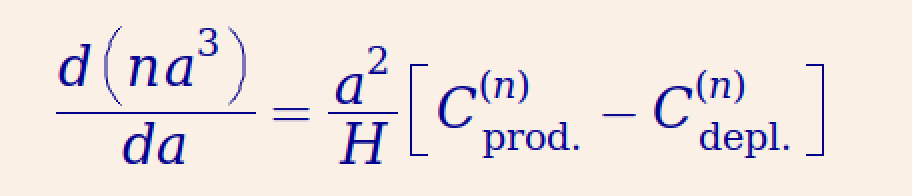

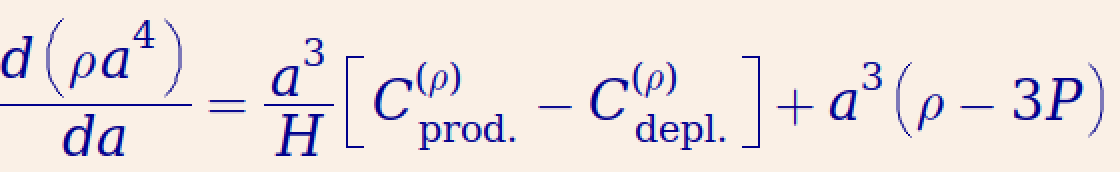

Define $Y=[n_{Z'}a^3,\rho_{Z'}a^4,n_{\nu}a^3,\rho_{\nu}a^4]$

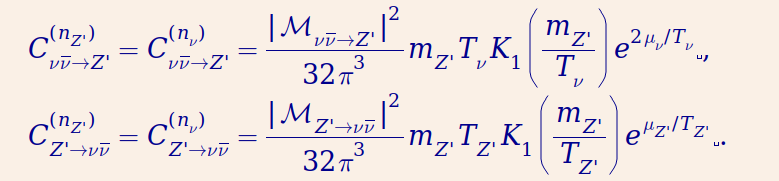

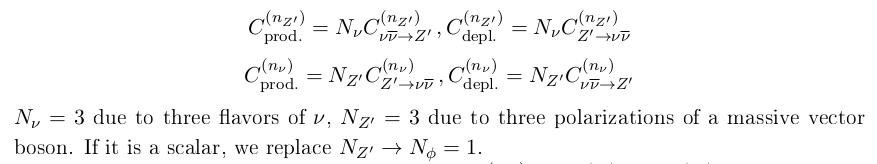

In [3]:
x_K1K2_max=550.0 #about this value, BesselK(1,x=m/T) and  BesselK(2,x=m/T) is problematic
# BesselK(2, 450.0), BesselK(2, 550.0), BesselK(2, 800.0),  BesselK(2, 800.0)==0
#output: (2.1915146417154464e-197, 7.368731826071644e-241, 0.0, True)

In [4]:
def C_nZ_ννZ(μν,Tν,m,M2):
    if m/Tν<x_K1K2_max:
        return  M2*m*Tν*BesselK(1,m/Tν) *Exp((2*μν)/Tν)/ (32.*Pi**3)
    else:
#         print("use approx formula")
        return  M2*m*Tν*BesselKExp_approx1(2*μν,Tν,m)/ (32.*Pi**3)
C_nν_ννZ=C_nZ_ννZ

def C_nZ_Zνν(μZ,TZ,m,M2):
    if m/TZ<x_K1K2_max:
        return  M2*m*TZ*BesselK(1,m/TZ)*Exp(μZ/TZ)/(32.*Pi**3)
    else:
        return  M2*m*TZ*BesselKExp_approx1(μZ,TZ,m)/(32.*Pi**3)
C_nν_Zνν=C_nZ_Zνν

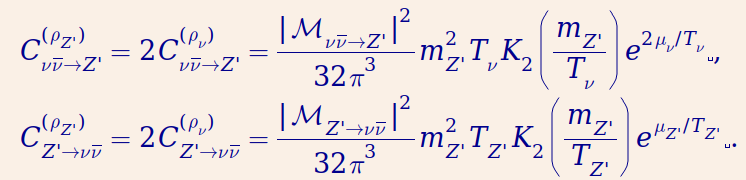

In [5]:
def C_ρZ_ννZ(μν,Tν,m,M2):
    if m/Tν<x_K1K2_max:
        return M2*m**2*Tν*BesselK(2,m/Tν)*Exp((2*μν)/Tν)/(32.*Pi**3)
    else:
        return M2*m**2*Tν* BesselKExp_approx2(2*μν,Tν,m) /(32.*Pi**3)
    
def C_ρν_ννZ(μν,Tν,m,M2): return 0.5*C_ρZ_ννZ(μν,Tν,m,M2)

def C_ρZ_Zνν(μZ,TZ,m,M2):
    if m/TZ<x_K1K2_max:
        return  M2*m**2*TZ*BesselK(2,m/TZ)*Exp(μZ/TZ)/(32.*Pi**3)
    else:
        return  M2*m**2*TZ* BesselKExp_approx2(μZ,TZ,m) /(32.*Pi**3)
         
def C_ρν_Zνν(μZ,TZ,m,M2): return 0.5*C_ρZ_Zνν(μZ,TZ,m,M2)

In [6]:
def BesselKExp_approx(μ,T,m):
    return (Exp((-m + μ)/T)*Sqrt(Pi/2.)*Sqrt(T))/Sqrt(m) #see 20230711.nb, (*label AB*)

def BesselKExp_approx1(μ,T,m):
    return Exp((-m + μ)/T)*((Sqrt(Pi/2.)*Sqrt(T))/Sqrt(m) + \
    (3*Sqrt(Pi/2.)*T**1.5)/(8.*m**1.5) - \
    (15*Sqrt(Pi/2.)*T**2.5)/(128.*m**2.5) + \
    (105*Sqrt(Pi/2.)*T**3.5)/(1024.*m**3.5)) #see 20230711.nb, (*label AB2*)

def BesselKExp_approx2(μ,T,m):
    return Exp((-m + μ)/T)*((Sqrt(Pi/2.)*Sqrt(T))/Sqrt(m) + \
        (15*Sqrt(Pi/2.)*T**1.5)/(8.*m**1.5) + \
        (105*Sqrt(Pi/2.)*T**2.5)/(128.*m**2.5) - \
        (315*Sqrt(Pi/2.)*T**3.5)/(1024.*m**3.5)) #see 20230711.nb, (*label AB2*)


def _test(T=0.01):
    m=1;μ=1;
    return BesselKExp_approx(μ,T,m), BesselK(1,m/T)*Exp(μ/T), BesselK(2,m/T)*Exp(μ/T),\
         [BesselKExp_approx1(μ,T,m), BesselK(1,m/T)*Exp(μ/T)],\
        [BesselKExp_approx2(μ,T,m),BesselK(2,m/T)*Exp(μ/T)]

_test()

(0.12533141373155002,
 0.12579995047957857,
 0.1276916206687182,
 [0.12579995065690433, 0.12579995047957857],
 [0.12769162027745226, 0.1276916206687182])

In [7]:
GeV=1e3    
mpl=1.22e19*GeV
a_dec=5

In [9]:
warning_count=0
def dYda(a,Y,para={"m":1.0,"M2":1e-20,"dof":3}):
    #"str.CP.approx":False, ,"NR.approx":False
#     global debug_var
    global warning_count
    a2,a3,a4=a**2,a**3,a**4
    m=para["m"];M2=para["M2"]
    nZ,ρZ,nν,ρν=Y/np.array([a3,a4,a3,a4])

#     if  (nZ<0) or (ρZ<0) or (nν<0)or (ρν<0):
#         print("negative Y. a,Y=",a,Y)
#         return [0,0,0,0]

    dofZ=para["dof"]
    dofν=3 #3 ν flavors
        
    ρ_tot=(dofZ*ρZ+2*dofν*ρν+ργe_from_a(a))
    H=Sqrt(8*Pi*ρ_tot/3)/mpl
    
    
    Tν,μν=Tμ_from_nρ(nν,ρν,0,"MB") #"FD")
    
    NR_approx_used=False
#     if m*a/10 >20 and ("NR.approx" in para) and para["NR.approx"]:    
#         #  here m*a/10 >20 is almost equivalent to m/Tν>20 due to Tν~10 MeV/a, but m*a/10 >20 is more stable.
#         print("debug, NR.approx is on! ")
#         Γ=M2/(16*Pi*m)
#         nZeq=nMB(μν,Tν,m)
#         C_nZ_ννZ_eval,C_nZ_Zνν_eval=Γ*nZeq,Γ*nZ
#         C_nν_ννZ_eval,C_nν_Zνν_eval=Γ*nZeq,Γ*nZ
#         C_ρZ_ννZ_eval,C_ρZ_Zνν_eval=m*Γ*nZeq,m*Γ*nZ
#         C_ρν_ννZ_eval,C_ρν_Zνν_eval=0.5*m*Γ*nZeq,0.5*m*Γ*nZ
#         C_ρminus3P=ρZ
#         NR_approx_used=True

#     if (nZ<1e-6 * nν) and (m/Tν<1e-6 * ρν):
#         return [0,0,0,0]
        
    
    if (nZ<0) or (ρZ<0):
        print("Warning! nZ or ρ<0 occured.  [a,Y]=",a,Y)
        raise Exception("negative n or ρ","max_step might be too small")
        
    

    if  NR_approx_used:
        pass
    else: # compute TZ,μZ, and then collision terms
        if ρZ<(nZ*m): 
            warning_count=warning_count+1
#             print("Warning!!!ρ/n<... #=",warning_count,"(nZ,ρZ,a,M2,m)=", (nZ,ρZ,a,M2,m))

            if warning_count>2:
                print("Warning!!!ρ/n<... #=",warning_count,"(nZ,ρZ,a,M2,m)=", (nZ,ρZ,a,M2,m))
                raise Exception('too much warning',"rho-n reset","max_step might be too small")

            ρZ=2*nZ*m # n rushes too fast, pull. !!! warining, this is an artifical effect.
            TZ,μZ= Tμ_from_nρ(nZ,ρZ,m,"MB")
        else:
            TZ,μZ=Tμ_from_nρ(nZ,ρZ,m,"MB") #"BE")
        C_nZ_ννZ_eval,C_nZ_Zνν_eval=C_nZ_ννZ(μν,Tν,m,M2), C_nZ_Zνν(μZ,TZ,m,M2)
        C_ρZ_ννZ_eval,C_ρZ_Zνν_eval=C_ρZ_ννZ(μν,Tν,m,M2), C_ρZ_Zνν(μZ,TZ,m,M2)
        C_nν_Zνν_eval,C_nν_ννZ_eval=C_nν_Zνν(μZ,TZ,m,M2), C_nν_ννZ(μν,Tν,m,M2)
        C_ρν_Zνν_eval,C_ρν_ννZ_eval=C_ρν_Zνν(μZ,TZ,m,M2), C_ρν_ννZ(μν,Tν,m,M2)
        C_ρminus3P=ρminus3P(μZ,TZ,m,"MB")
    
    bkf=1   #bkf=BacK reaction factor. bkf=0 means Z doesn't return energy at all.
    fwf=1   #fwf=ForWard reaction factor. fwf=0 means Z doesn't get energy from ν at all.
    if "small_n.approx" in para:
        bkf=Exp(-(1e-8*ρν/ρZ)**2) # if ρZ<<1e-8*ρν, we suppress the back reaction in a mild way
#         bkf=1/(1+(1e-8*ρν/ρZ)**2) # if ρZ<<1e-8*ρν, we suppress the back reaction in a mild way
#         ρZeq=ρMB(μν,Tν,m)
#         fwf=... # similar to the above
    

    #debug 
#     if not "dof" in para:
#         print(para)
    

    
#     if ("str.CP.approx" in para) and (para["str.CP.approx"]==True) and (abs(TZ/Tν-1)<1e-2):
    if ("str.CP.approx" in para) and (para["str.CP.approx"]==True):
        Γ= Sqrt((C_nZ_ννZ_eval/nν)**2+(C_nZ_Zνν_eval/nZ)**2)  #Γ=M2/(16*Pi*m) is only suitable for NR decay
        λ=1e-3
        if ("str.CP.approx_λ" in para): λ=para["str.CP.approx_λ"]
        H=Sqrt((λ*Γ)**2+H**2)
#         if Γ/H>30:
#             print("str.CP.approx applied" )
#             H=Γ/3 # here is the explanation: 
        #It is already in thermal-EQ. If the reaction is too fast, we reduce the reaction rate
        #techinally, reducing Γ is  equivalent to incrasing H, because the RHS= a^2 C/H
        
    dY4= [a2/H *(fwf*dofν*C_nZ_ννZ_eval- bkf*dofν*C_nZ_Zνν_eval),
            a3/H *(fwf*dofν*C_ρZ_ννZ_eval- bkf*dofν*C_ρZ_Zνν_eval)+a3*C_ρminus3P,
            a2/H *(bkf* dofZ*C_nν_Zνν_eval-fwf*dofZ*C_nν_ννZ_eval),
            a3/H *(bkf* dofZ*C_ρν_Zνν_eval-fwf*dofZ*C_ρν_ννZ_eval)+0
           ]
    if a<a_dec:
        #before nu decouples, we assume that it can always get sufficient energy 
        #from the SM thermal to compensate the loss.
        dY4[2]=0;dY4[3]=0; 
    return dY4

 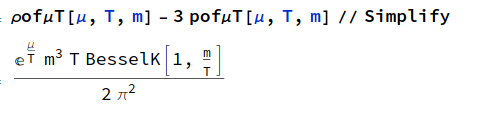

In [11]:
def ρminus3P(μ,T,m,dist="MB"):
    if m==0: 
        return 0
    if m/T<x_K1K2_max:
        return (Exp(μ/T)*m**3*T*BesselK(1,m/T))/(2.*Pi**2)
    else:
        return (m**3*T* BesselKExp_approx(μ,T,m))/(2.*Pi**2)

def nMB(μ,T,m):
    if μ==T==0: return 0
    if m==0: return Exp(μ/T)*T**3/Pi**2
    if m/T<x_K1K2_max:
        return Exp(μ/T)*m**2*T*BesselK(2,m/T)/(2.*Pi**2)
    else:
        return m**2*T*BesselKExp_approx(μ,T,m)/(2.*Pi**2)

def ρMB(μ,T,m):
    if μ==T==0: return 0
    if m==0: return 3*Exp(μ/T)*T**4/Pi**2
    if m/T<x_K1K2_max:
        return Exp(μ/T)*m**2*T*(m*BesselK(1,m/T) + 3*T*BesselK(2,m/T))/(2.*Pi**2)
    else: 
        return m**2*T*(m* BesselKExp_approx(μ,T,m) + 3*T* BesselKExp_approx(μ,T,m) )/(2.*Pi**2)

log_a_Tγ_ργ_data=Log(np.loadtxt("data/a_T_gamma_rho_gamma.dat")
                 )    
ργe_max=Exp(log_a_Tγ_ργ_data[-1,2])

def ργe_from_a(a):
    if a<1:
        return ργe_max/a**4
    return Exp(np.interp(Log(a),log_a_Tγ_ργ_data[::-1,0],log_a_Tγ_ργ_data[::-1,2])) 
def Tγe_from_a(a):
    if a<1:
        return 10/a #by definition, a=1 corresponds to T=10MeV.
    return Exp(np.interp(Log(a),log_a_Tγ_ργ_data[::-1,0],log_a_Tγ_ργ_data[::-1,1])) 
    

In [12]:
MBratio_data=np.loadtxt("data/MBratio_data.dat")
log_MBratio_data=Log(MBratio_data)

def Tμ_from_nρ(n,ρ,m,dist="MB"):
    if n==ρ==0: return [0,0]
    if m==0: 
#         print("debug")
        T=ρ/(3*n); μ=T* Log(Pi**2 *n/T**3); return (T,μ)
    
    r=ρ/(m * n)
    if r<=1: print("ρ,m,n=",[ρ,m, n]); raise ValueError
    #x,r defined as x=m/T, r=ρ/(m * n)
    x = Exp(np.interp(Log(r),log_MBratio_data[::-1,1],log_MBratio_data[::-1,0])
           )
    #     the format of MBratio_data is
    #     MBratio_data=[[x1,r1],[x2,r2], ...]

    T = m/x;
#     print("debug, x=",x)
    if x<x_K1K2_max:
        K2 = BesselK(2, x);
        if K2 == 0.0:
            print("debug","r",r,"n",n,"x=",x,"K2",K2,"T=",T,"m=",m)#"K2*...",(K2*m**2*T),
            raise ValueError
        μ=T*Log(n*2*Pi**2/(K2*m**2*T)) # see  20230711.nb (*label n-to-mu*)

    else:
#         use the expression obtained in  20230711.nb (*label use Kexp-> approx*)
        μ=m - T*Log((m**1.5*T**1.5)/(2.*Sqrt(2)*n*Pi**1.5))
        
    return (T,μ)

In [17]:
Tμ_from_nρ(1e-20,1.003e-20,1),Tμ_from_nρ(1e-20,1.0028e-20,1)

((0.0019950345130975394, 0.9322227277430145),
 (0.0018623385730721813, 0.9369235395843978))

In [19]:
a_1eV=1.4e7 # a=1  corresponds to  T=10MeV; a=1.4e7  corresponds to  Tγ=1 eV. 
#below this temperature, you'll have R-M equality (0.8eV) and recombination(0.25eV).

In [20]:
def sol_extract(sol,para):
    a_list=sol.t
    nZ_list,ρZ_list,nν_list,ρν_list=sol.y[0]/a_list**3,sol.y[1]/a_list**4,sol.y[2]/a_list**3,sol.y[3]/a_list**4

    TZ_list,μZ_list,Tν_list,μν_list=0*a_list,0*a_list,0*a_list,0*a_list
    for i in range(len(a_list)):
        TZ_list[i],μZ_list[i]=Tμ_from_nρ(nZ_list[i],ρZ_list[i],m=para["m"]) 
        Tν_list[i],μν_list[i]=Tμ_from_nρ(nν_list[i],ρν_list[i],m=0)
        
    dofZ=para["dof"]
        
        
    ρtot_inv_list=(dofZ * ρZ_list+6*ρν_list)
    
    ρνa4_initial=para["Y0"][-1]
    Neff_initial=(ρtot_inv_list*a_list**4)[0]/(2*ρνa4_initial)
    Neff_final=(ρtot_inv_list*a_list**4)[-1]/(2*ρνa4_initial)
    Neff_ν=(6*ρν_list*a_list**4)[-1]/(2*ρνa4_initial) 
    #the remaining part of ρZ would be non-relativistic and has no contribution
    
    n_ratio=nZ_list/(nZ_list+nν_list)
    
    if a_list[-1]>a_1eV:
        print ("Warning: temperature < 1eV. Calculation is invalid after R-M equality and recombination")
    
    if (n_ratio[-1]/max(n_ratio)>0.01 ) and (a_list[-1]<a_1eV):
        print ("Warning: more than 1% of dark particles have not decayed! a_max might be too small! frac="\
               , n_ratio[-1]/max(n_ratio)," Tν_final=",Tν_list[-1])
    
    return {"a":a_list,"nZ":nZ_list,"ρZ":ρZ_list,"nν":nν_list,"ρν":ρν_list,
    "TZ":TZ_list,"μZ":μZ_list,"Tν":Tν_list,"μν":μν_list,"ρtot_inv":ρtot_inv_list,
           "Neff_2":[Neff_initial,Neff_final],"delta_Neff":Neff_ν-3,"n_ratio":n_ratio}

 Next, we need to set the initial value of $Y=[n_{Z'}a^3,\rho_{Z'}a^4,n_{\nu}a^3,\rho_{\nu}a^4]$ at $\nu$-dec.

 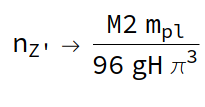

 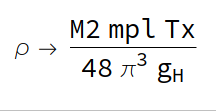

 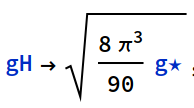

In [21]:
Tγ_gρ_gs_data=np.loadtxt("data/T_gamma_grho_gs.dat")

def gH(Tγ):
    gρ=np.interp(Tγ,Tγ_gρ_gs_data[:,0],Tγ_gρ_gs_data[:,1])
    return Sqrt(8*Pi**3 * gρ/90)

def nZ_initial(Tγ,para):
    if Tγ<2*para["m"]:
        raise "the formula is only applicable to relativistic production"
    M2=para["M2"]
    dofν=3 #three ν flavors
    return dofν*M2*mpl/(96*gH(Tγ)*Pi**3)  #According to 20230707.nb, (*label 333n*)

def ρZ_initial(Tγ,para):
    return 2*Tγ *nZ_initial(Tγ,para) #according to 20230707.nb, (*label 333rho*)

def Y0_from_amin(a_min,para):
    a=a_min
    Tν=Tγe_from_a(a)
    μν=0
    nν=nMB(μν,Tν,m=0)
    ρν=ρMB(μν,Tν,m=0)
    nZ=nZ_initial(Tν,para)
    ρZ=ρZ_initial(Tν,para)
    if (nZ>0.5*nν) or (ρZ>0.5*ρν):
        raise "initial value too large, the approximate formula is not applicable."
    Y0=[nZ*a**3,ρZ*a**4,nν*a**3,ρν*a**4]
    return Y0


In [22]:
def estimate_a_max(model,stop_at_1eV=True):
    m=model["m"]
    M2=model["M2"]
    a_max=5e-9 * Sqrt(m/M2)   #this comes from  (*label xxx*) in 20230711.nb
#     a_max=max(a_max,100, 200/m) #200/m comes from (*label xxxyyy*) in 20230711.nb
    a_max=max(a_max, 200/m) #200/m comes from (*label xxxyyy*) in 20230711.nb
    if not stop_at_1eV:
        return  a_max
    else:
        return min(a_max,a_1eV)

# solve ODE for $m<1$ MeV

In [23]:
# model

[3.0000000002229563, 3.2411754988173582]


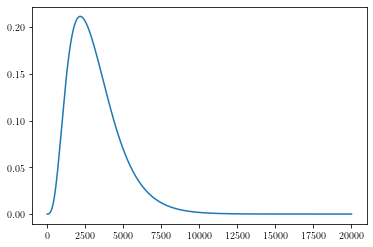

In [24]:
a_min,a_max=1,20000

model={"m":0.01,"M2":1e-26,"dof":3}
model["Y0"]=Y0_from_amin(a_min,model)

sol=si.solve_ivp(lambda a,Y: dYda(a,Y,para=model),
                     t_span=[a_min,a_max],y0=model["Y0"],method='BDF',max_step=a_max/3000)
model.update(sol_extract(sol,para=model) )

plt.plot(model["a"],model["nZ"]/(model["nZ"]+model["nν"]))


print(model["Neff_2"])

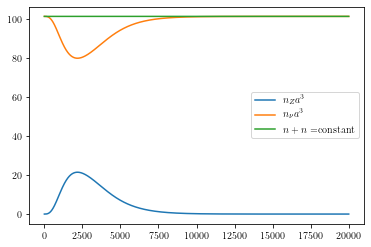

In [25]:
plt.plot(model["a"],model["nZ"]*model["a"]**3,label=r"$n_Z a^3$")
plt.plot(model["a"],model["nν"]*model["a"]**3,label=r"$n_{\nu}a^3$")
plt.plot(model["a"],model["nZ"]*model["a"]**3+model["nν"]*model["a"]**3,label="$n+n=$constant")
plt.legend()

In [28]:
def ana_approx(m,M2,Tν):
    gHν=6
    Γ=3*M2/(16*Pi*m)
    T_begin=(0.4*m)
    T_end=((M2*mpl*3)/(96.*m*Pi)   )**0.5
    n_ratio_top=(3*M2*mpl)/(128.* m**3)
    n_max=9*M2 *Tν**3 * mpl/(64*Pi**2 * gHν* m**3)
    if Tν > T_begin:
        return n_max* 2/(9*Pi) *(m/Tν)**3
    elif T_begin>= Tν >= T_end:
        return n_max*1
    elif Tν < T_end:
        return n_max*Exp(-(Tν**-2 - T_end**-2)/(2*gHν) *Γ*mpl)
    
def ana_approx2(m,M2,Tν):
    gHν=6
    Γ=3*M2/(16*Pi*m)
    T_begin=(0.4*m)
    T_end=((M2*mpl*3)/(96.*m*Pi)   )**0.5
    n_ratio_top=(3*M2*mpl)/(128.* m**3)
    n_max=9*M2 *Tν**3 * mpl/(64*Pi**2 * gHν* m**3)
    if Tν > T_begin:
        return n_max* 2/(9*Pi) *(m/Tν)**3
    else:
        return n_max*Exp(-(Tν**-2 - T_begin**-2)/(2*gHν) *Γ*mpl)

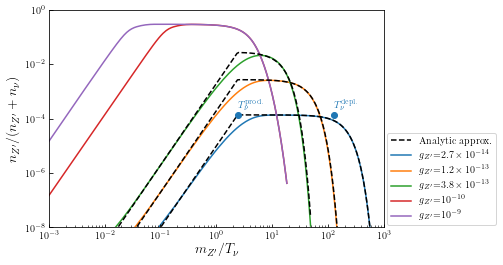

In [30]:
fig, axs=plt.subplots(ncols=1,figsize=[6,4],sharey=False)
ax=axs


a_min=1

Neff_result=[]

# for i,M2 in enumerate([0.5e-33,1e-32,1e-31,1e-26,1e-24]):
for i, gZ in enumerate([2.7e-14, 1.2e-13, 3.8e-13, 1e-10,1e-09]):
    gZlabel=[r"$2.7\times 10^{-14}$",r"$1.2\times 10^{-13}$",r"$3.8\times 10^{-13}$",
             r"$10^{-10}$",r"$10^{-9}$"]
    m=0.001
    M2=2/3*(gZ*m)**2
    model={"m":m,"M2":M2,"dof":3}


    
    a_max=estimate_a_max(model)

    model["Y0"]=Y0_from_amin(a_min,model)

    sol=si.solve_ivp(lambda a,Y: dYda(a,Y,para=model),
                         t_span=[a_min,a_max],y0=model["Y0"],method='BDF',max_step=a_max/300)
    model.update(sol_extract(sol,para=model) )
    col="C"+str(i)


    nZapprox_list= [ana_approx(m,M2,Tν) for Tν in model["Tν"]]
    nZapprox2_list= [ana_approx2(m,M2,Tν) for Tν in model["Tν"]]   
    T_begin=(0.4*m)
    T_end=((M2*mpl*3)/(96.*m*Pi)   )**0.5
    n_ratio_top=(3*M2*mpl)/(128.* m**3)
    if i==0:
        plt.plot( m/model["Tν"],nZapprox2_list/(nZapprox2_list+model["nν"]),ls="--",color="k",
         label="Analytic approx.")
        plt.scatter([ m/T_begin, m/T_end],[n_ratio_top]*2,color=col,zorder=10)
        
        plt.text(x=m/T_begin,y=1.5*n_ratio_top, s=r"$T_{\nu}^{{\rm prod.}}$",color=col,zorder=10)
        plt.text(x=m/T_end,y=1.5*n_ratio_top, s=r"$T_{\nu}^{{\rm depl.}}$",color=col,zorder=10)

    if i in [1,2]:
        plt.plot( m/model["Tν"],nZapprox2_list/(nZapprox2_list+model["nν"]),ls="--",color="k")
#         plt.plot( m/model["Tν"],nZapprox_list/(nZapprox_list+model["nν"]),ls="--",color=col)

    
    plt.plot(model["m"]/model["Tν"],model["n_ratio"],color=col,label="$g_{Z'}$="+gZlabel[i],zorder=-5)
    Neff_result.append(model["Neff_2"])
    
#         plt.plot([m/T_begin,m/T_end],[n_ratio_top]*2,ls="--",color=col)
# plt.plot([1e1,1e5],[0.3]*2,ls="--")



plt.loglog()
# plt.savefig("")



ax.tick_params(which='both', direction='in')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-8,1)
ax.set_xlim(1e-3,1e3)

ax.set_xlabel(r"$m_{Z'}/T_{\nu}$",fontsize=14)
ax.set_ylabel(r"$n_{Z'}/(n_{Z'}+n_{\nu})$ ",fontsize=14)

# plt.legend(loc="upper right")
plt.legend(loc=[1.01,0.01])
# plt.grid()
# plt.savefig("../fig/approx.pdf",bbox_inches='tight')
plt.show()

In [31]:
Neff_result

[[3.0, 3.0109765808942432],
 [3.0, 3.0445834413486943],
 [3.000000000000002, 3.1135476459051423],
 [3.0000000001486375, 3.2546805840047615],
 [3.0000000148637818, 3.2550437737802485]]

In [32]:
def estimate_M2_subMeV(model):
    m=model["m"]
    return {"M2_min":1e-24 *m**3,"M2_max":2.0271e-19} 
    #2.0271e-19 is obtained from 20230711.nb, label (*label M2max*)
    # 1e-24 *m**3 is obtained from 20230711.nb, label (*label 1e-24*)


In [33]:
def ΔNeff_lgM2(model,lgM2,n_max_step):
    model["M2"]=10**lgM2
    
    if 0.9999*model["M2_min"]<=model["M2"]<=1.0001*model["M2_max"]:
        pass
    else:
        raise ValueError
        
    a_max=estimate_a_max(model,stop_at_1eV=True)
    a_min=1
    model["Y0"]=Y0_from_amin(a_min,model)
    sol=si.solve_ivp(lambda a,Y: dYda(a,Y,para=model),
                         t_span=[a_min,a_max],y0=model["Y0"],method='BDF',
                     max_step=a_max/n_max_step )
#                      max_step=min(100,a_max/n_max_step))
    model.update(sol_extract(sol,para=model) )
    return model["delta_Neff"]
    

def M2_scan(m,opt={"auto_n":True}):
    global warning_count
    model={"m":m,"dof":None}
    model["dof"]=opt["dof"]
    model.update(opt)
    model.update(estimate_M2_subMeV(model))
    
    if m<1e-4:
        model["M2_max"]=1e-20 *(m/1e-4)**3
    
    if "length" in opt:
        length=opt["length"]
    else:
        length=20
        
        
    if "lgM2_list" in opt:
        lgM2_list=opt["lgM2_list"]
        length=len(lgM2_list)
    else:
        lgM2_list=np.linspace(Log10(model["M2_min"]),Log10(model["M2_max"]),length)
        
    ΔNeff_list=0*lgM2_list
    

    for i,lgM2 in enumerate(lgM2_list):
        if (not("n" in opt) ) and (not("auto_n" in opt) ):
            raise "opt wrong"
        if ("n" in opt):
            warning_count=0
            n_max_step=opt["n"]        
            ΔNeff_list[i]=ΔNeff_lgM2(model,lgM2,n_max_step)
        if "auto_n" in opt:
            
            for n_max_step in  (200,400,800,1600,3200): #range(100,1100,100):
                warning_count=0
                try: 
                    ΔNeff_list[i]=ΔNeff_lgM2(model,lgM2,n_max_step)
#                     print("successful run with n_max_step=",n_max_step)
                    break
                except Exception as inst:
                    if "max_step might be too small"  in inst.args:
#                         print("tried and failed, n_max_step=",n_max_step)
                        pass
                    else:
                        raise "unknown error"                               
    return {"ΔNeff":ΔNeff_list,"lgM2":lgM2_list}
    

In [1055]:

Timing_begin()
m_list=np.concatenate([np.geomspace(0.5e-5,1e-4,30), np.geomspace(2e-4,1,10)])
result=[]
for i,m in enumerate(m_list):
    print("### computing m=",m, "i=",i,"len=",len(m_list))
    Neff_lgM2=M2_scan(m,opt={"auto_n":True,"length":100,"dof":3,"str.CP.approx":True})
# M2_scan(m,opt={"auto_n":True,"length":50,"dof":1,"str.CP.approx":True})
    result.append( Neff_lgM2)
Timing_end()

### computing m= 4.9999999999999996e-06 i= 0 len= 40
### computing m= 5.544126201879396e-06 i= 1 len= 40
### computing m= 6.147467068473121e-06 i= 2 len= 40
### computing m= 6.8164666499025106e-06 i= 3 len= 40
### computing m= 7.558270271592301e-06 i= 4 len= 40
### computing m= 8.380800850724198e-06 i= 5 len= 40
### computing m= 9.292843517846633e-06 i= 6 len= 40
### computing m= 1.0304139447451704e-05 i= 7 len= 40
### computing m= 1.1425489899687216e-05 i= 8 len= 40
### computing m= 1.2668871584432861e-05 i= 9 len= 40
### computing m= 1.4047564579899886e-05 i= 10 len= 40
### computing m= 1.557629417200318e-05 i= 11 len= 40
### computing m= 1.72713881294368e-05 i= 12 len= 40
### computing m= 1.915095109424787e-05 i= 13 len= 40
### computing m= 2.1235057950506108e-05 i= 14 len= 40
### computing m= 2.3545968236365615e-05 i= 15 len= 40
### computing m= 2.6108363889570926e-05 i= 16 len= 40
### computing m= 2.894961286567435e-05 i= 17 len= 40
### computing m= 3.2100061444570014e-05 i= 18 le

In [1056]:
np.save("data/M2-Neff-below1MeV.npy",result)
np.save("data/M2-Neff-below1MeV_mlist.npy",m_list)

In [908]:
Timing_begin()
m_list=np.concatenate([np.geomspace(0.5e-5,1e-4,20), np.geomspace(2e-4,1,10)])
result=[]
for i,m in enumerate(m_list):
    print("### computing m=",m, "i=",i,"len=",len(m_list))
    Neff_lgM2=M2_scan(m,opt={"auto_n":True,"length":100,"dof":1,"str.CP.approx":True}) #,"small_n.approx":True
    result.append( Neff_lgM2)
Timing_end()


### computing m= 4.9999999999999996e-06 i= 0 len= 30
### computing m= 5.853899568613902e-06 i= 1 len= 30
### computing m= 6.853628031883591e-06 i= 2 len= 30
### computing m= 8.024090035856701e-06 i= 3 len= 30
### computing m= 9.394443439884112e-06 i= 4 len= 30
### computing m= 1.0998825680021061e-05 i= 5 len= 30
### computing m= 1.2877204180706934e-05 i= 6 len= 30
### computing m= 1.5076371999678692e-05 i= 7 len= 30
### computing m= 1.765111350903633e-05 i= 8 len= 30
### computing m= 2.0665569151220554e-05 i= 9 len= 30
### computing m= 2.4194833267898108e-05 i= 10 len= 30
### computing m= 2.8326824805926804e-05 i= 11 len= 30
### computing m= 3.3164477502323234e-05 i= 12 len= 30
### computing m= 3.882830410883109e-05 i= 13 len= 30
### computing m= 4.5459398534539144e-05 i= 14 len= 30
### computing m= 5.3222950694157126e-05 i= 15 len= 30
### computing m= 6.231236162177695e-05 i= 16 len= 30
### computing m= 7.295406136340671e-05 i= 17 len= 30
### computing m= 8.541314966877575e-05 i= 18 l

In [909]:
np.save("data/M2-Neff-below1MeV-phi.npy",result)
np.save("data/M2-Neff-below1MeV-phi_mlist.npy",m_list)

In [927]:
result=np.load("data/M2-Neff-below1MeV-phi.npy",allow_pickle=True)

# solve ODE for $m>1$ MeV

In [36]:
    
    
def M2_scan2(m,opt={"dof":3}):
    global warning_count
    M2_list=np.geomspace(1e-24* m**3,1e-15,30)
    if "M2_list" in opt:
        M2_list=opt["M2_list"]
#     if m>=1:
        
#     else:
#         M2_list=np.geomspace(1e-24* m**3,1e-19*(m/1e-4),30)
    Neff_list=[]
    for temp in M2_list:
        model={"m":m,"M2":temp,"dof":opt["dof"]}
        model.update(opt)
        
        a_min=0.01
        
#debug
#         if temp<1e-24* m**3:
#             a_min=2
            
        
        a_max=estimate_a_max(model,stop_at_1eV=True)
        model["Y0"]=Y0_from_amin(a_min,model)
        
        sol=None


        for n_max_step in  (200,400,800,1600,3200): #range(100,1100,100):
            warning_count=0
            try: 
                sol=si.solve_ivp(lambda a,Y: dYda(a,Y,para=model),
                             t_span=[a_min,a_max],y0=model["Y0"],method='Radau',max_step=a_max/n_max_step)
#                     print("successful run with n_max_step=",n_max_step)
                break
            except Exception as inst:
                if "max_step might be too small"  in inst.args:
#                         print("tried and failed, n_max_step=",n_max_step)
                    pass
                else:
                    print(inst.args)
                    raise "unknown error"  
            sol=None
        if sol==None:
            Neff_list.append(-100)
        else:
            model.update(sol_extract(sol,para=model) )
            Neff_list.append(model["delta_Neff"])

    return {"ΔNeff":Neff_list,"lgM2":Log10(M2_list),"M2":M2_list}

In [37]:
Timing_begin()
m_list=np.array([1e-4,1e-2,1,8.0,13.0,20]) #
M2_max_list=[2e-19,1e-16,1e-15,1e-15,1e-15,1e-15]
len_list=[60,60,30,30,30,30]
result=[]
for i,m in enumerate(m_list):
    print("### computing m=",m, "i=",i,"len=",len(m_list))
    result.append( M2_scan2(m,opt={"dof":3,"str.CP.approx":True,
                                   "M2_list":np.geomspace(1e-24* m**3,M2_max_list[i],len_list[i])}))
Timing_end()

### computing m= 0.0001 i= 0 len= 6
### computing m= 0.01 i= 1 len= 6
### computing m= 1.0 i= 2 len= 6
Warning! nZ or ρ<0 occured.  [a,Y]= 5.750850743123474 [ -51.96207258 -688.05045164   68.37190985 2982.05568219]
Warning! nZ or ρ<0 occured.  [a,Y]= 5.630783265203631 [ -24.35160382 -163.66653663   66.24507942 2545.61301721]
### computing m= 8.0 i= 3 len= 6
### computing m= 13.0 i= 4 len= 6
### computing m= 20.0 i= 5 len= 6
time used: 77.01184296607971


In [38]:
np.save("data/M2-Neff-bench.npy",result)
np.save("data/M2-Neff-bench_mlist.npy",m_list)

In [39]:
result2=np.copy(result)

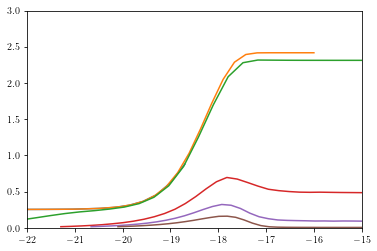

In [40]:
for i,m in enumerate(m_list):
    Neff_lgM2=result2[i]
    plt.plot(Neff_lgM2["lgM2"],Neff_lgM2["ΔNeff"])
#     print(max(Neff_lgM2["lgM2"]))
plt.xlim(-22,-15)
plt.ylim(0,3)
plt.show()

In [1023]:
Timing_begin()
m_list=np.geomspace(1,200,100)
result=[]
for i,m in enumerate(m_list):
    print("### computing m=",m, "i=",i,"len=",len(m_list))
    result.append( M2_scan2(m,opt={"dof":3,"str.CP.approx":True}))
Timing_end()


### computing m= 1.0 i= 0 len= 100
Warning! nZ or ρ<0 occured.  [a,Y]= 5.750850743123474 [ -51.96207258 -688.05045164   68.37190985 2982.05568219]
Warning! nZ or ρ<0 occured.  [a,Y]= 5.630783265203631 [ -24.35160382 -163.66653663   66.24507942 2545.61301721]
### computing m= 1.0549763580417753 i= 1 len= 100
Warning! nZ or ρ<0 occured.  [a,Y]= 5.7924738501532 [  -80.5571012  -1591.90238882    52.38071697  2468.79305458]
Warning! nZ or ρ<0 occured.  [a,Y]= 5.515393546816813 [  -6.02374701  316.86736798   71.606672   2619.85654787]
### computing m= 1.112975116027088 i= 2 len= 100
### computing m= 1.1741624344973793 i= 3 len= 100
### computing m= 1.2387136088955097 i= 4 len= 100
### computing m= 1.3068135717693687 i= 5 len= 100
Warning! nZ or ρ<0 occured.  [a,Y]= 5.374012787735577 [ -17.87884646   78.6280124    71.92233783 2827.3130086 ]
### computing m= 1.3786574225848127 i= 6 len= 100
### computing m= 1.4544509866657862 i= 7 len= 100
### computing m= 1.5344114048629378 i= 8 len= 100
### 

In [1025]:
np.save("data/M2-Neff-above1MeV.npy",result)
np.save("data/M2-Neff-above1MeV_mlist.npy",m_list)

In [705]:
Timing_begin()
m_list=np.geomspace(1,100,100)
result=[]
for i,m in enumerate(m_list):
    print("### computing m=",m, "i=",i,"len=",len(m_list))
    result.append( M2_scan2(m,opt={"dof":1,"str.CP.approx":True}))
Timing_end()

### computing m= 1.0 i= 0 len= 100
### computing m= 1.0403065027260043 i= 1 len= 100
Warning! nZ or ρ<0 occured.  [a,Y]= 6.381263927303963 [ -25.89170773 -146.58657117   68.98908453 2698.63756865]
### computing m= 1.08223761961401 i= 2 len= 100
### computing m= 1.1258588331791666 i= 3 len= 100
Warning! nZ or ρ<0 occured.  [a,Y]= 5.232322056843705 [-3.29799718e-01  5.90101092e+02  7.69320007e+01  2.82328236e+03]
### computing m= 1.1712382653077986 i= 4 len= 100
Warning! nZ or ρ<0 occured.  [a,Y]= 6.130093663336163 [ -113.07469131 -2210.26215351    54.13276714  2849.32813964]
### computing m= 1.2184467836412278 i= 5 len= 100
Warning! nZ or ρ<0 occured.  [a,Y]= 6.066548531443628 [ -106.68492608 -2071.85613452    54.6926133   2813.03134387]
### computing m= 1.2675581122475543 i= 6 len= 100
### computing m= 1.318648946754229 i= 7 len= 100
### computing m= 1.3717990741212212 i= 8 len= 100
### computing m= 1.4270914972418183 i= 9 len= 100
### computing m= 1.4846125645656532 i= 10 len= 100
###

In [706]:
np.save("data/M2-Neff-above1MeV-phi.npy",result)
np.save("data/M2-Neff-above1MeV-phi_mlist.npy",m_list)